In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pde_functions import PDE_plotter_1D
from matplotlib import cm
from matplotlib.animation import FuncAnimation

## 2D (Linear) Wave Equation is a Linear Hyperbolic PDE:
## $u_{tt} = c^{2}(u_{xx} + u_{yy}), \tiny\text{where c = a constant}$

### Initial Conditions and Boundary Conditions
- Both BC and IC are set directly here in these functions
- IC currently set to create a Gaussian spike around xc and yc with width w (set using **kwargs)
- BCs are zero at both ends

In [152]:
# Initial Condition Functions
def f_u_0_xy(t_grid,x_grid, y_grid,**kwargs):
    '''
    Assigns the initial values (t=0) for U, inner nodes.
    If the initial value is a constant, leave function as-is.
    If the initial value is a function of x, replace return value with function.
    
    Parameters: 
    **kwargs - Enter in any arguments necessary for the funciton to run.
    '''
    # Initialize Solution
    U = np.zeros([len(t_grid),len(x_grid),len(y_grid)])
    
    # For t=0, multiple the contributions of a gaussian spike from x and y
    for i, x in enumerate(x_grid):
        for j, y in enumerate(y_grid):
            U[0,i,j] = (np.exp(-(x-xc)**2/w**2)) * (np.exp(-(y-yc)**2/w**2))
            
    # Set boundary conditions 
    U[0,:,0] = U[0,:,-1] = U[0,0,:] = U[0,-1,:] = 0

    # Copy the first 2D ICs into the second index
    U[1,:,:] = U[0,:,:]
    
    return U
    

def f_u_t_0(t):
    '''
    Assigns the initial value for the 0-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float]    
    '''    
    return 0

def f_u_t_L(t):
    '''
    Assigns the initial value for the L-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return 0

### Explicit Solver Function

In [150]:
def wave_2D_explicit_timestep(u_line,u_line_previous,c,x,y,dt,dx,dy):
    '''
    Takes in:
    u_line [1D array] - Values of the wave equation at time now (used to rpedict next step)
    u_line_previous [1d array] - Values of the wave equation at the previous step
    m [int] - The space index being examined
    dt [float] - Time step
    dx [float] - X step
    
    Returns:
    The next time evolution step of the 1D linear wave equation.
    
    Uses Centered Finite Difference Approximations in Space and Time to determine the evolution of the wave
    equation.
    '''
    # Break up u_line and u_line previous into x and y
    
    
    return (dt**2 * c**2) * (((u_line[x+1,y] + u_line[x-1,y] - 2*u_line[x,y])/dx**2) + ((u_line[x,y+1] + u_line[x,y-1] - 2*u_line[x,y])/dy**2)) + 2*u_line[x,y] - u_line_previous[x,y]

### Parameters
Along with IC and BC, these parameters need to be set by the user

In [178]:
# Wave Domain Information
L = 1 # Length, in units long
t_max = 5 # Time in seconds

# Domain step size
dx = dy = .01 # Space step is .01 length units

# Wave propogation speed
c = .5 # Length units per second

# Initial Parameters for Gaussian Pulse 
xc = yc = L * .5 # Where from 0 to L the pulse is centered
w = .1 # The Gaussian Pulse width

### Run this cell to create the discretized array which solves the PDE

In [170]:
# Create a dt that meets CFL conditions
dt = dx/c * .5 # Added the .5 factor to ensure well below the CFL, not just at it

# Calculates a node number
Nx = Ny = int(L/dx) + 1 # Add an extra node to include x at L, remove later
Nt = int(t_max/dt) + 1 #Add an extra node to include t at t_max, remove later

# Creates node grids
x_grid = np.linspace(0,L,Nx)
y_grid = np.linspace(0,L,Ny)
t_grid = np.linspace(0,t_max,Nt)

# -- Create solution data holder (automatically populated with initial conditions from above)
U = f_u_0_xy(t_grid,x_grid, y_grid,xc=xc,yc=yc,w=w)

# Evolves the wave through the rest of the time steps
for t in range(2,len(t_grid)):    
    for x in range(1,len(x_grid)-1):
        for y in range(1,len(y_grid)-1):
            u_line = U[t-1] # This represents an x-y grid timeslice
            u_line_previous = U[t-2]
            U[t,x,y] = wave_2D_explicit_timestep(u_line,u_line_previous,c,x,y,dt,dx,dy)

    # Append the first and last value with boundary conditions (0 in this case)
    # Note: This doesn't use the boundary conditions functions from the top, its just easier this way manually inputting
    U[t,:,0] = U[t,:,-1] = U[t,0,:] = U[t,-1,:] = 0

### Plot
Just need to update time step.  Each step in a single dt, not a second or anything, so you always start from t=0.

<IPython.core.display.Javascript object>


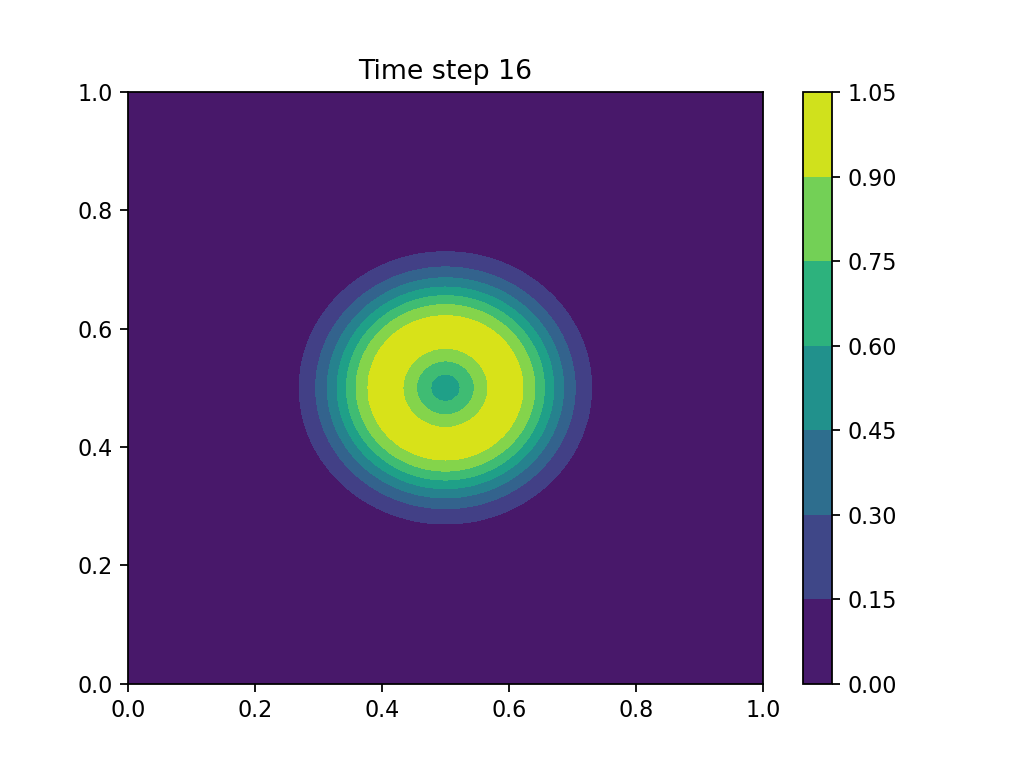

In [179]:
time_steps = 50

# !-Leave below alone
%matplotlib notebook 

X, Y = np.meshgrid(x_grid, y_grid)

# Sets up the figure and axis
fig, ax = plt.subplots()

# Initializes the plot - start with the first timestep
contour = ax.contourf(X, Y, U[0, :, :], cmap='viridis')
cbar = fig.colorbar(contour)  # Add colorbar for reference

# Function to initialize the plot (called once)
def init():
    global contour  # Ensure we refer to the global contour variable
    contour = ax.contourf(X, Y, U[0, :, :], cmap='viridis')
    return contour.collections

# Function to update the plot for each time step
def update_plot(frame):
    global contour  # Refer to the global contour object
    for c in contour.collections:
        c.remove()  # Remove the old contour before updating
    contour = ax.contourf(X, Y, U[frame, :, :], cmap='viridis')
    ax.set_title(f"Time step {frame}")
    return contour.collections

# Creates the animation
ani = FuncAnimation(fig, update_plot, frames=time_steps, init_func=init, interval=200, blit=False)

# Displays the animation
plt.show()